1. Data Preprocessing

In [2]:
#import the file startup_data.csv
#This file contains information about startups, including their name, location, and funding amount.
import pandas as pd
df = pd.read_csv('startup_data.csv')
print(df.tail())
print(df.info())

     Unnamed: 0 state_code   latitude   longitude zip_code       id  \
918         352         CA  37.740594 -122.376471    94107  c:21343   
919         721         MA  42.504817  -71.195611     1803  c:41747   
920         557         CA  37.408261 -122.015920    94089  c:31549   
921         589         CA  37.556732 -122.288378    94404  c:33198   
922         462         CA  37.386778 -121.966277    95054  c:26702   

              city            Unnamed: 6                  name  labels  ...  \
918  San Francisco                   NaN               CoTweet       1  ...   
919     Burlington    Burlington MA 1803    Reef Point Systems       0  ...   
920      Sunnyvale                   NaN       Paracor Medical       0  ...   
921  San Francisco                   NaN               Causata       1  ...   
922    Santa Clara  Santa Clara CA 95054  Asempra Technologies       1  ...   

    object_id has_VC has_angel has_roundA  has_roundB  has_roundC  has_roundD  \
918   c:21343    

In [3]:
#check the data types of the columns
print(df.columns)
print(df.dtypes)
print(df.describe())

Index(['Unnamed: 0', 'state_code', 'latitude', 'longitude', 'zip_code', 'id',
       'city', 'Unnamed: 6', 'name', 'labels', 'founded_at', 'closed_at',
       'first_funding_at', 'last_funding_at', 'age_first_funding_year',
       'age_last_funding_year', 'age_first_milestone_year',
       'age_last_milestone_year', 'relationships', 'funding_rounds',
       'funding_total_usd', 'milestones', 'state_code.1', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
       'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA',
       'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants',
       'is_top500', 'status'],
      dtype='object')
Unnamed: 0                    int64
state_code                   object
latitude                    float64
longitude                   float64
zip_code          

In [4]:
#check the missing values in the dataset
print(df.isnull().sum())

Unnamed: 0                    0
state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
Unnamed: 6                  493
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
state_code.1                  1
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobil

In [5]:
#transform the 'status' column to a binary column
df["status_binary"] = df["status"].apply(lambda x: 1 if x == "acquired" else 0)
print(df["status_binary"].value_counts())

status_binary
1    597
0    326
Name: count, dtype: int64


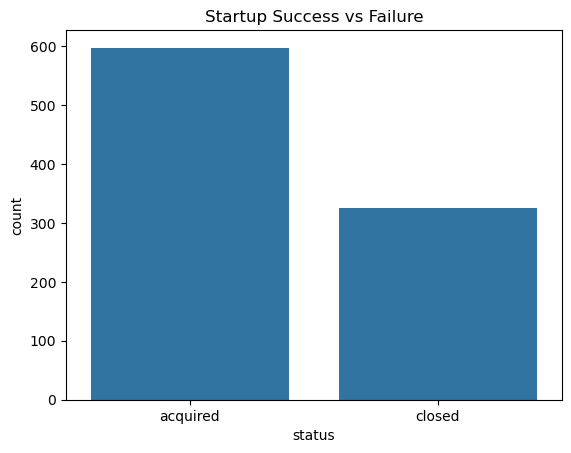

In [6]:
#check the balance of the target dataset
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x="status", data=df)
plt.title("Startup Success vs Failure")
plt.show()

In [7]:
# Convert all categorical columns to numerical using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)
# Fill missing values with the mean of each column
df_encoded = df_encoded.fillna(df_encoded.mean())
print(df_encoded.head())
print(df_encoded.dtypes)



   Unnamed: 0   latitude   longitude  labels  age_first_funding_year  \
0        1005  42.358880  -71.056820       1                  2.2493   
1         204  37.238916 -121.973718       1                  5.1260   
2        1001  32.901049 -117.192656       1                  1.0329   
3         738  37.320309 -122.050040       1                  3.1315   
4        1002  37.779281 -122.419236       0                  0.0000   

   age_last_funding_year  age_first_milestone_year  age_last_milestone_year  \
0                 3.0027                    4.6685                   6.7041   
1                 9.9973                    7.0055                   7.0055   
2                 1.0329                    1.4575                   2.2055   
3                 5.3151                    6.0027                   6.0027   
4                 1.6685                    0.0384                   0.0384   

   relationships  funding_rounds  ...  object_id_c:967  object_id_c:971  \
0              3 

In [8]:
#check the data is clean and ready for analysis
print(df_encoded.isnull().sum())

Unnamed: 0                0
latitude                  0
longitude                 0
labels                    0
age_first_funding_year    0
                         ..
object_id_c:9782          0
object_id_c:9816          0
object_id_c:9822          0
object_id_c:997           0
status_closed             0
Length: 5434, dtype: int64


In [9]:
#check the data types of the columns after one-hot encoding
print(df_encoded.select_dtypes(include=['object']).columns)

Index([], dtype='object')


2. Feature selection using filter correlation and random forest

In [10]:
#implement a correlation matrix to check the correlation between the features and the target variable
plt.figure(figsize=(12, 8))
correlation = df_encoded.corr()["status_binary"].sort_values(ascending=False)
print(correlation)


labels                1.000000
status_binary         1.000000
relationships         0.360434
milestones            0.328260
is_top500             0.310652
                        ...   
is_otherstate        -0.169067
closed_at_7/1/2013   -0.173933
closed_at_1/1/2012   -0.206864
closed_at_6/1/2013   -0.211829
status_closed        -1.000000
Name: status_binary, Length: 5434, dtype: float64


<Figure size 1200x800 with 0 Axes>

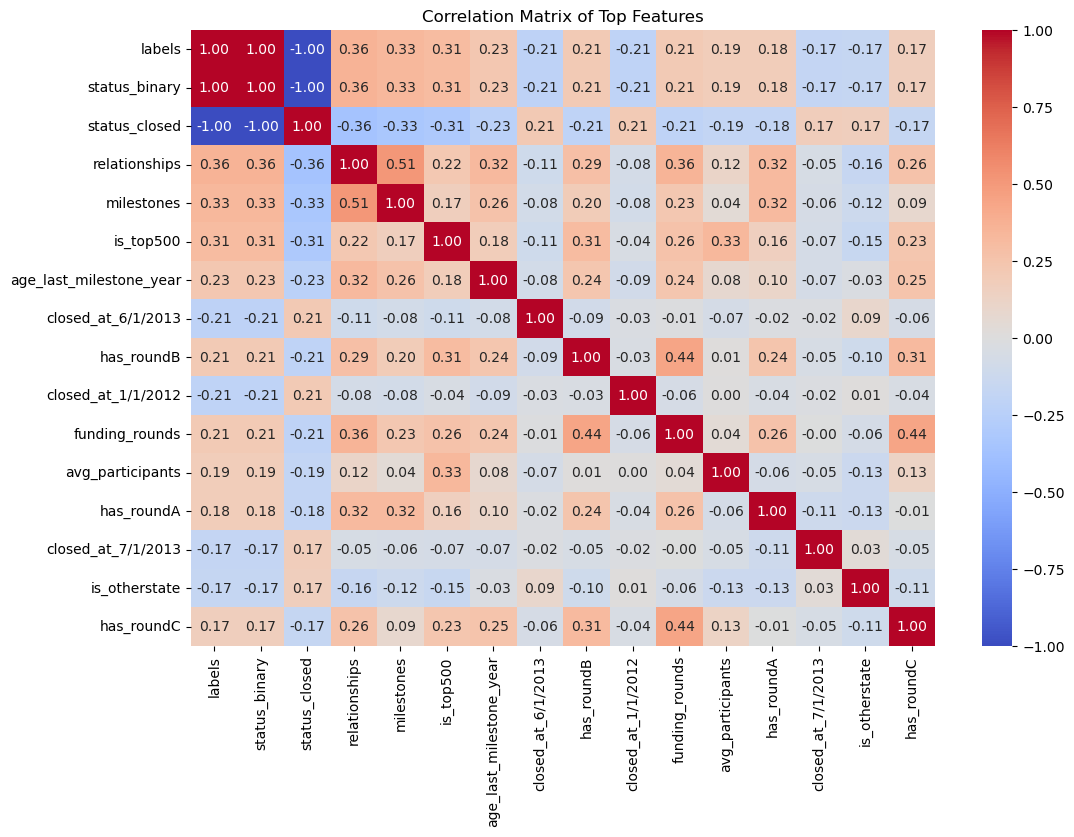

In [11]:
# visualize the the most correlated features with the target variable using a heatmap
corr_matrix = df_encoded.corr()
top_features = corr_matrix['status_binary'].abs().sort_values(ascending=False).head(16).index  # 1 for target + 15 features

plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Top Features")
plt.show()

In [12]:
# find the most important features using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Features and target
X = df_encoded.drop('status_binary', axis=1)
y = df_encoded['status_binary']

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importances_df = importances_df.sort_values(by='importance', ascending=False)

print(importances_df.head(20))  # Show top 10 features

                       feature  importance
3                       labels    0.242531
5432             status_closed    0.178940
8                relationships    0.030832
10           funding_total_usd    0.019718
7      age_last_milestone_year    0.019174
4       age_first_funding_year    0.016409
11                  milestones    0.015063
5        age_last_funding_year    0.013811
34                   is_top500    0.012752
6     age_first_milestone_year    0.012471
33            avg_participants    0.010228
2985        closed_at_1/1/2012    0.008335
1                     latitude    0.007582
2                    longitude    0.007288
9               funding_rounds    0.007169
0                   Unnamed: 0    0.006942
30                  has_roundB    0.005509
3116        closed_at_6/1/2013    0.004698
29                  has_roundA    0.003535
3129        closed_at_7/1/2013    0.003504


C:\Users\zulfa\AppData\Local\Temp\ipykernel_37820\2895007255.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features['importance'], y=top_features['feature'], palette="viridis")


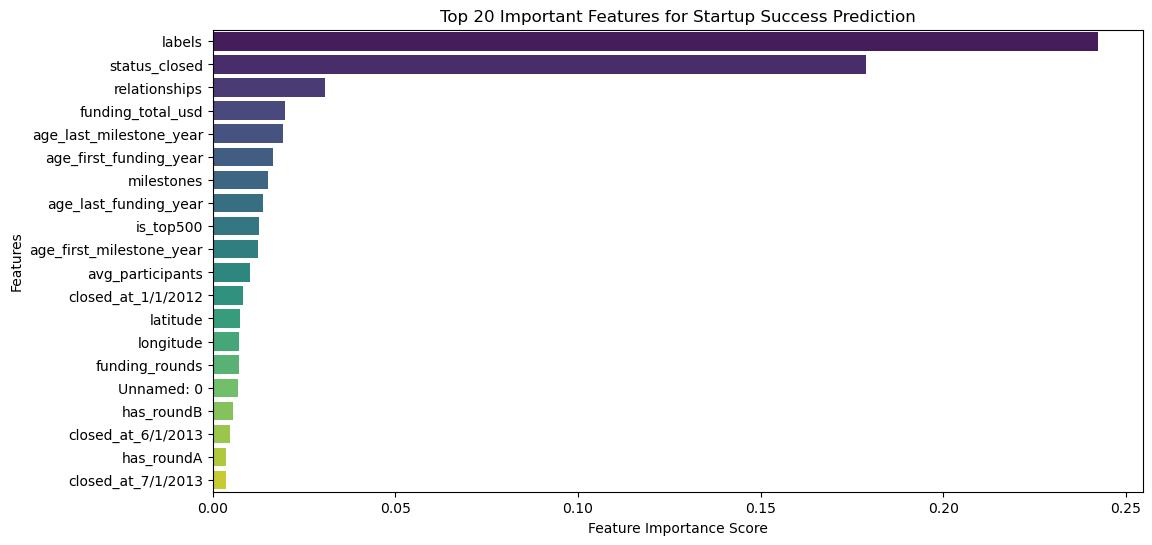

In [13]:
#visualize the 20 most important features using random forest classifier
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 20 features for visualization
top_features = importances_df.head(20)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=top_features['importance'], y=top_features['feature'], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 20 Important Features for Startup Success Prediction")
plt.show()


###In Summary, Use Random Forest feature importances for model building and feature selection. Use correlation for initial exploration and understanding linear relationships. So we are going to use the random forest for feature selection which are above features because in our dataset there are unnumerical data

3. Train and evaluate the model 

In [24]:
#use Decision Tree Classifier with class weighting to handle class imbalance and evaluate the model using hold-out validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Select top features and drop unnecessary columns in this case we drop 'labels' and 'status_closed' because they are leaking infromation about the target variable (status_binary)
top_features = importances_df['feature'].head(24).tolist()
X_selected = df_encoded[top_features].drop(columns=['labels','status_closed'], axis=1)
y = df_encoded['status_binary']

# Hold-out split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Decision Tree with class weighting
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.60      0.60        65
           1       0.78      0.78      0.78       120

    accuracy                           0.71       185
   macro avg       0.69      0.69      0.69       185
weighted avg       0.71      0.71      0.71       185



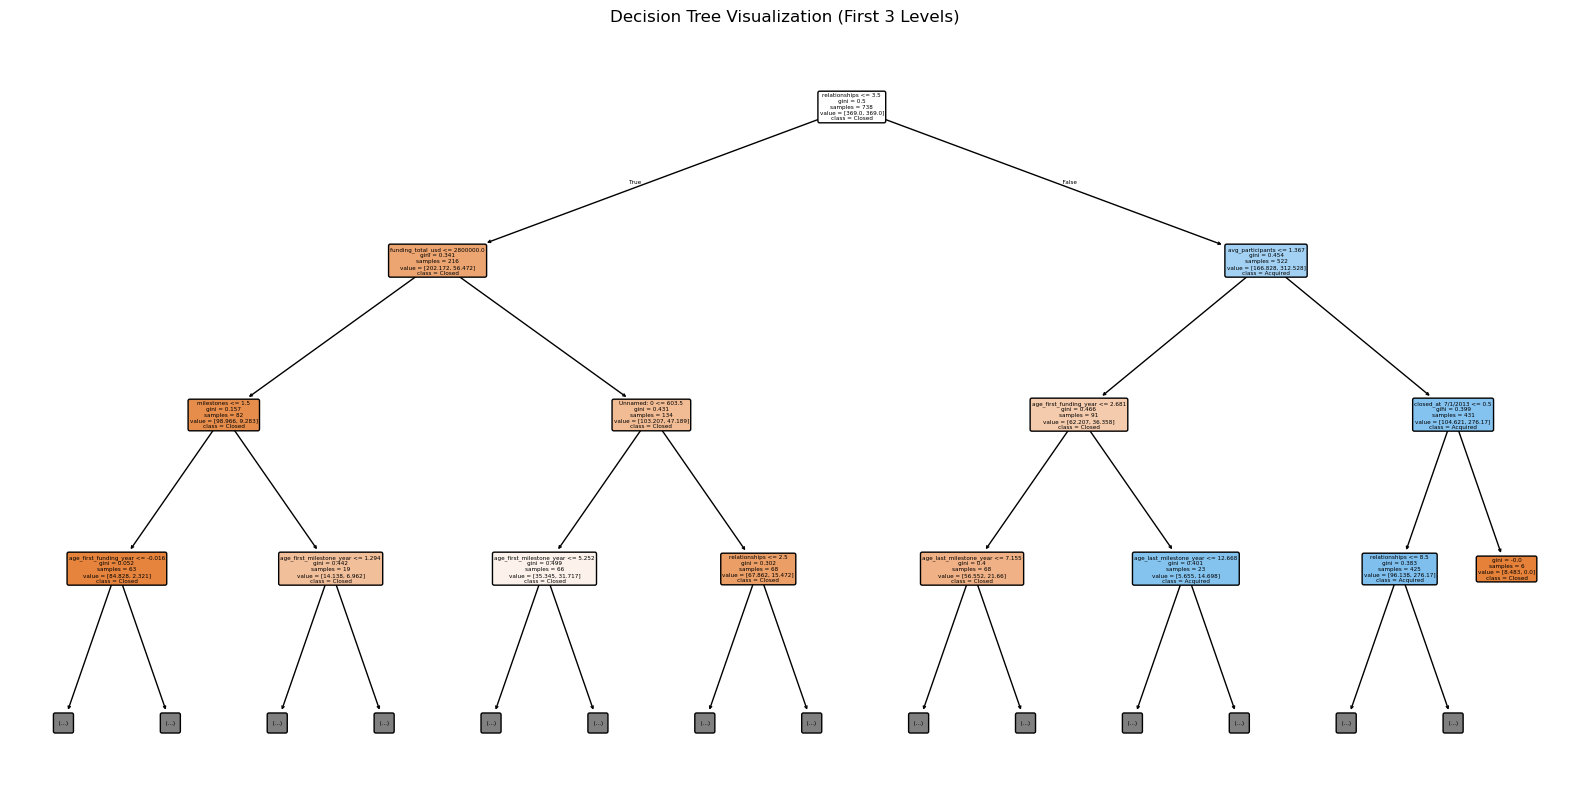

In [19]:
# visualize the decision tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    dt, 
    feature_names=X_selected.columns, 
    class_names=['Closed', 'Acquired'], 
    filled=True, 
    rounded=True, 
    max_depth=3 # Limit depth for readability
)
plt.title("Decision Tree Visualization (First 3 Levels)")
plt.show()

In [17]:
#using KNN Classifier with scaling and hold-out validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Select top features (same as before)
top_features = importances_df['feature'].head(29).tolist()
X_selected = df_encoded[top_features].drop(columns=['labels','status_closed'], axis=1)
y = df_encoded['status_binary']

# Hold-out split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# KNN with scaling
knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5, weights='distance')
)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72        65
           1       0.85      0.84      0.85       120

    accuracy                           0.80       185
   macro avg       0.78      0.78      0.78       185
weighted avg       0.80      0.80      0.80       185



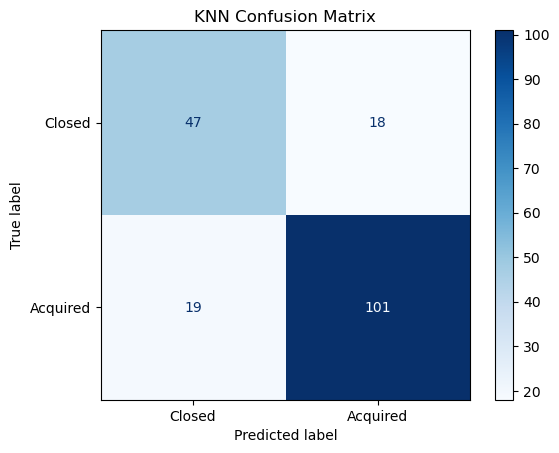

In [18]:
#visualize the confusion matrix for KNN Classifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Predict on test set (already done)
# y_pred = knn.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Closed', 'Acquired'])
disp.plot(cmap=plt.cm.Blues)
plt.title("KNN Confusion Matrix")
plt.show()